OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [896]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [2]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [3]:
from functions import *

In [4]:
import os, warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action="once")

In [5]:
# Set random integer (seed) - 891
from random import randrange
seed = randrange(1000)
print("Seed value: ", seed)

Seed value:  31


#### Loading dataset

In [6]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
#  "Neighborhood",
category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'Neighborhood': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [7]:
path = "./dataset/cleaned/"
filename = "2016_Building_Energy_Prediction.csv"
dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type
data = pd.read_csv(dataset_path, dtype=category_types, sep=",")

In [8]:
data.shape

(3157, 37)

In [9]:
data.dtypes

OSEBuildingID                             int64
BuildingType                           category
PrimaryPropertyType                    category
ZipCode                                category
CouncilDistrictCode                    category
Neighborhood                           category
YearBuilt                                 int64
NumberofBuildings                       float64
NumberofFloors                            int64
PropertyGFATotal                          int64
PropertyGFAParking                        int64
PropertyGFABuilding(s)                    int64
LargestPropertyUseType                 category
LargestPropertyUseTypeGFA               float64
SecondLargestPropertyUseType           category
SecondLargestPropertyUseTypeGFA         float64
ThirdLargestPropertyUseType            category
ThirdLargestPropertyUseTypeGFA          float64
ENERGYSTARScore                         float64
SiteEnergyUse(kBtu)                     float64
SteamUse(kBtu)                          

In [10]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [11]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'Log-NumberofBuildings',
       'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFAParking',
       'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA',
       'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA', 'Log-SiteEnergyUse(kBtu)',
       'Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)',
       'Log-TotalGHGEmissions'],

In [12]:
features_for_prediction = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "Log-NumberofFloors", "Log-PropertyGFATotal", "Log-PropertyGFABuilding(s)", "Log-SecondLargestPropertyUseTypeGFA", "Log-ThirdLargestPropertyUseTypeGFA"]

#features_for_prediction = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA",
   #                        "BuildingType","PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

variable_to_predict = "Log-Electricity(kBtu)"

features_for_prediction.append(variable_to_predict)
print(features_for_prediction)


['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'Log-Electricity(kBtu)']


In [13]:
data = data[features_for_prediction]

data

,BuildingType,PrimaryPropertyType,Neighborhood,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-Electricity(kBtu)
0,Multifamily LR (1-4),Low-Rise Multifamily,central,1.386294,9.939819,9.939819,0.000000,0.000000,13.612540
1,NonResidential,Warehouse,greater duwamish,1.098612,10.164158,10.164158,9.076352,8.026497,14.012813
2,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,1.386294,10.131459,10.131459,0.000000,0.000000,12.624928
3,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,2.772589,11.210455,11.210455,0.000000,0.000000,14.583001
4,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,1.386294,10.501884,10.287184,8.343078,0.000000,13.397146
...,...,...,...,...,...,...,...,...,...
3152,NonResidential,Mixed Use Property,lake union,1.386294,10.641321,10.392129,9.555985,9.177920,14.707138
3153,Multifamily LR (1-4),Low-Rise Multifamily,lake union,1.609438,10.509469,10.509469,0.000000,0.000000,13.156997
3154,NonResidential,Small- and Mid-Sized Office,lake union,1.791759,10.426469,10.230306,9.078294,7.313887,14.071242
3155,NonResidential,Retail Store,lake union,1.098612,9.929009,9.929009,8.987322,0.000000,12.487428


## I) Feature Engineering : preparing the vectors and matrices


#### 1) Separating training data and target vector

In [14]:
# we create the data matrix / we only take the features
X = data[data.columns[:-1]]

# we create the target vector
y = data[variable_to_predict].values # numpy array not a DataFrame anymore

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

Shape of X : (3157, 8)
Shape of y : (3157,)


In [15]:
X

,BuildingType,PrimaryPropertyType,Neighborhood,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
0,Multifamily LR (1-4),Low-Rise Multifamily,central,1.386294,9.939819,9.939819,0.000000,0.000000
1,NonResidential,Warehouse,greater duwamish,1.098612,10.164158,10.164158,9.076352,8.026497
2,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,1.386294,10.131459,10.131459,0.000000,0.000000
3,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,2.772589,11.210455,11.210455,0.000000,0.000000
4,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,1.386294,10.501884,10.287184,8.343078,0.000000
...,...,...,...,...,...,...,...,...
3152,NonResidential,Mixed Use Property,lake union,1.386294,10.641321,10.392129,9.555985,9.177920
3153,Multifamily LR (1-4),Low-Rise Multifamily,lake union,1.609438,10.509469,10.509469,0.000000,0.000000
3154,NonResidential,Small- and Mid-Sized Office,lake union,1.791759,10.426469,10.230306,9.078294,7.313887
3155,NonResidential,Retail Store,lake union,1.098612,9.929009,9.929009,8.987322,0.000000


#### 2) Separation train and test dataset


In [16]:
print("We have to separate the train / test sets before normalising the dataset.")

We have to separate the train / test sets before normalising the dataset.


In [17]:
# We create a training set and a test set (the test set contains 30% of the dataset)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,  random_state=seed)

In [18]:
X_train.shape

(2209, 8)

In [19]:
X_test.shape

(948, 8)

#### 3) Normalization

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [21]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [22]:
X.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = X.select_dtypes(['category','object']).columns
#numerical_columns = X.select_dtypes(include='number').columns.drop("YearBuilt")
numerical_columns = X.select_dtypes(include='number').columns
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (3,)
Shape of numerical variables : (5,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [23]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 5 numerical features to standardize.

Index(['Log-NumberofFloors', 'Log-PropertyGFATotal',
       'Log-PropertyGFABuilding(s)', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [24]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scale = StandardScaler().fit(X_train[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = std_scale.transform(X_train[numerical_columns])
X_test_std[numerical_columns] = std_scale.transform(X_test[numerical_columns])

print("Before")
display(X_train)
print("After")
display(X_train_std)

Before


,BuildingType,PrimaryPropertyType,Neighborhood,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
22,NonResidential,Worship Facility,ballard,1.098612,10.090838,10.090838,0.000000,0.000000
1021,Multifamily MR (5-9),Mid-Rise Multifamily,east,1.945910,11.330168,11.330168,9.479298,6.731018
2516,Multifamily LR (1-4),Low-Rise Multifamily,east,1.386294,9.952563,9.952563,0.000000,0.000000
1543,Multifamily MR (5-9),Mid-Rise Multifamily,magnolia / queen anne,2.079442,10.249839,10.249839,7.824446,0.000000
137,Multifamily LR (1-4),Low-Rise Multifamily,east,1.386294,10.158169,10.158169,0.000000,0.000000
...,...,...,...,...,...,...,...,...
826,Multifamily HR (10+),High-Rise Multifamily,downtown,2.564949,11.169590,11.169590,8.244597,0.000000
2658,Multifamily HR (10+),High-Rise Multifamily,magnolia / queen anne,2.484907,11.090401,11.090401,0.000000,0.000000
2942,Multifamily LR (1-4),Low-Rise Multifamily,northeast,1.609438,10.455532,10.455532,0.000000,0.000000
2064,NonResidential,Large Office,downtown,2.890372,12.844040,12.591083,11.330348,9.594241


After


,BuildingType,PrimaryPropertyType,Neighborhood,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
22,NonResidential,Worship Facility,ballard,-0.788100,-0.941065,-0.921859,-0.959295,-0.452684
1021,Multifamily MR (5-9),Mid-Rise Multifamily,east,0.687155,0.483434,0.569958,1.004788,1.590186
2516,Multifamily LR (1-4),Low-Rise Multifamily,east,-0.287209,-1.099999,-1.088305,-0.959295,-0.452684
1543,Multifamily MR (5-9),Mid-Rise Multifamily,magnolia / queen anne,0.919650,-0.758307,-0.730465,0.661907,-0.452684
137,Multifamily LR (1-4),Low-Rise Multifamily,east,-0.287209,-0.863675,-0.840812,-0.959295,-0.452684
...,...,...,...,...,...,...,...,...
826,Multifamily HR (10+),High-Rise Multifamily,downtown,1.764982,0.298864,0.376666,0.748961,-0.452684
2658,Multifamily HR (10+),High-Rise Multifamily,magnolia / queen anne,1.625618,0.207843,0.281344,-0.959295,-0.452684
2942,Multifamily LR (1-4),Low-Rise Multifamily,northeast,0.101313,-0.521882,-0.482867,-0.959295,-0.452684
2064,NonResidential,Large Office,downtown,2.331585,2.223495,2.087759,1.388320,2.459176


We can check that the numerical variables have a Standard Normal distribution.


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

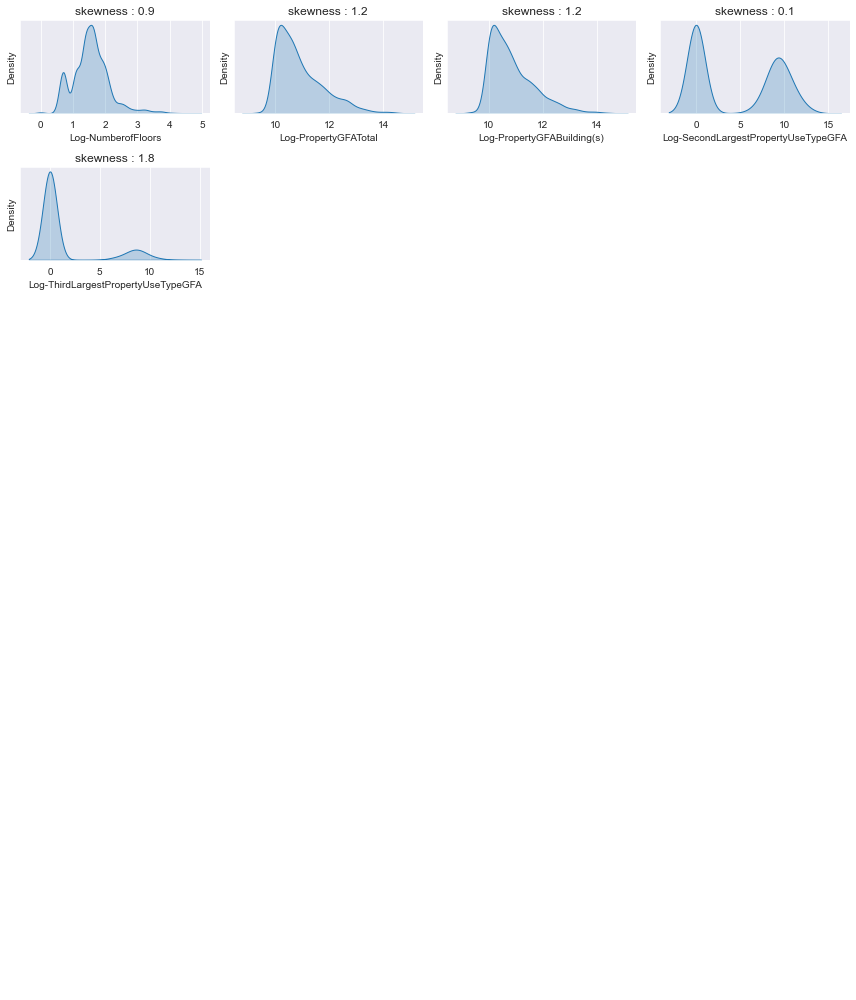

In [25]:
print("We can check that the numerical variables have a Standard Normal distribution.")
densite(X_train[numerical_columns])

##### 2) Feature Encoding : One Hot Encoder

In [26]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood'], dtype='object')


In [27]:
X.dtypes # we check that we have categories

BuildingType                           category
PrimaryPropertyType                    category
Neighborhood                           category
Log-NumberofFloors                      float64
Log-PropertyGFATotal                    float64
Log-PropertyGFABuilding(s)              float64
Log-SecondLargestPropertyUseTypeGFA     float64
Log-ThirdLargestPropertyUseTypeGFA      float64
dtype: object

In [28]:
X[categorical_columns].nunique()

BuildingType            8
PrimaryPropertyType    23
Neighborhood           13
dtype: int64

In [29]:
X_train_std[categorical_columns]

,BuildingType,PrimaryPropertyType,Neighborhood
22,NonResidential,Worship Facility,ballard
1021,Multifamily MR (5-9),Mid-Rise Multifamily,east
2516,Multifamily LR (1-4),Low-Rise Multifamily,east
1543,Multifamily MR (5-9),Mid-Rise Multifamily,magnolia / queen anne
137,Multifamily LR (1-4),Low-Rise Multifamily,east
...,...,...,...
826,Multifamily HR (10+),High-Rise Multifamily,downtown
2658,Multifamily HR (10+),High-Rise Multifamily,magnolia / queen anne
2942,Multifamily LR (1-4),Low-Rise Multifamily,northeast
2064,NonResidential,Large Office,downtown


##### Encoding the categorical features of the train set


In [30]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([X[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 44 columns to encodes the categorical features.


In [31]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(X_train_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(X_train_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
X_train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=X_train_std.index)
display(X_train_encoded.sort_index())

We have indeed : 43 labels after encoding the categorical variables.


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# 5) Concatenate the two dataframes for the training set

print("We need to add YearBuilt to the list of features.")
numerical_columns.tolist()
features_to_merge = numerical_columns.tolist().copy()
#features_to_merge.append("YearBuilt")
print(features_to_merge, end="\n\n")

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_train_std_encoded = pd.merge(X_train_std[features_to_merge].sort_index(), X_train_encoded.sort_index(), left_index=True, right_index=True)
display(X_train_std_encoded.sort_index())

We need to add YearBuilt to the list of features.
['Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA']

ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,-0.287209,-1.114647,-1.103645,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.788100,-0.856790,-0.833602,0.921299,1.983365,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287209,-0.894374,-0.872962,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.101313,-0.389977,-0.344728,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,-0.788100,1.053271,1.166724,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,-0.788100,-0.551886,-0.514288,1.013698,1.754706,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,-0.287209,-0.308334,-0.559187,1.020677,2.332823,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.101313,-0.459886,-0.417941,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.418759,-0.555287,-0.753977,0.921701,1.767087,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding the categorical features of the test set

In [33]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(X_test_std[categorical_columns])

print("ASK JEREMY for this method below ???")
# 5.2) we recreate a dataframe with the column names and the numpy array
X_test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=X_test_std.index)
display(X_test_encoded.sort_index())

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_test_std_encoded = pd.merge(X_test_std[features_to_merge].sort_index(), X_test_encoded.sort_index(), left_index=True, right_index=True)
display(X_test_std_encoded.sort_index())

ASK JEREMY for this method below ???


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3145,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
3,2.126509,0.345834,0.425856,-0.959295,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.287209,-0.468604,-0.685512,0.769366,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287209,0.909765,1.016436,1.039183,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,1.764982,0.552232,0.642008,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,-0.788100,-1.089379,-1.077182,0.876133,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0.687155,0.658263,0.753049,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3145,2.515031,3.019734,3.010906,1.494665,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,-0.287209,-0.653711,-0.620926,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.418759,-0.044487,0.017089,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Save
#X_train_std_encoded.to_csv("dataset/cleaned/electricity/X_train.csv", index=False)
#X_test_std_encoded.to_csv("dataset/cleaned/electricity/X_test.csv", index=False)
#y_train.to_csv("dataset/cleaned/electricity/y_train.csv", index=False)
#y_test.to_csv("dataset/cleaned/electricity/y_test.csv", index=False)

## II) Modelisation

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [36]:
print("We can start now the modelling to predict the feature wanted.")

display(X_train_std_encoded)
display(X_test_std_encoded)
print(y_train.shape, y_test.shape)

We can start now the modelling to predict the feature wanted.


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,-0.287209,-1.114647,-1.103645,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.788100,-0.856790,-0.833602,0.921299,1.983365,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287209,-0.894374,-0.872962,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.101313,-0.389977,-0.344728,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,-0.788100,1.053271,1.166724,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,-0.788100,-0.551886,-0.514288,1.013698,1.754706,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,-0.287209,-0.308334,-0.559187,1.020677,2.332823,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3153,0.101313,-0.459886,-0.417941,-0.959295,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3154,0.418759,-0.555287,-0.753977,0.921701,1.767087,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
3,2.126509,0.345834,0.425856,-0.959295,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.287209,-0.468604,-0.685512,0.769366,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287209,0.909765,1.016436,1.039183,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,1.764982,0.552232,0.642008,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,-0.788100,-1.089379,-1.077182,0.876133,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0.687155,0.658263,0.753049,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3145,2.515031,3.019734,3.010906,1.494665,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,-0.287209,-0.653711,-0.620926,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.418759,-0.044487,0.017089,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2209,) (948,)


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [38]:
print("We rename X_train_std_encoded to X_train, the same for X_test.")
X_train = X_train_std_encoded.copy()
X_test = X_test_std_encoded.copy()

X_train
X_test

We rename X_train_std_encoded to X_train, the same for X_test.


,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
3,2.126509,0.345834,0.425856,-0.959295,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.287209,-0.468604,-0.685512,0.769366,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.287209,0.909765,1.016436,1.039183,-0.452684,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,1.764982,0.552232,0.642008,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,-0.788100,-1.089379,-1.077182,0.876133,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0.687155,0.658263,0.753049,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3145,2.515031,3.019734,3.010906,1.494665,-0.452684,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,-0.287209,-0.653711,-0.620926,-0.959295,-0.452684,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3150,0.418759,-0.044487,0.017089,-0.959295,-0.452684,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1) Linear modelling : Linear Regression / Ridge Regression / Lasso / Elastic Net


In [39]:
X_train.shape

(2209, 48)

In [40]:
X_test.shape

(948, 48)

#### 1) Dummy Regression : baseline

In [41]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

pd.set_option('display.float_format', lambda x: '%.5f' % x)

global results
results = pd.DataFrame({})

def evaluate_regression(model_name, results, y_test, y_pred):
    print("Prediction for : ", variable_to_predict)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    #print("RMSE : {:.2f}".format(rmse))
    #print("MAE : {:.2f}".format(mae))
    #print("MSE : {:.2f}".format(mse))
    #print("R² : {:.2f}".format(r2))
    results = pd.concat([results, pd.DataFrame({"Model" : [model_name],
                               "RMSE" : [rmse],
                                "MSE": [mse],
                                "MAE" : [mae],
                                "Median Absolute Error": [median_ae],
                               "R² = 1 - RSE" : [r2]})])
    display(results)

    # 2) graph
    plt.title("Scatter plot of the predicted values as a function of the true values.")
    plt.legend("If the prediction was good, we would see a line.")
    plt.figure(0)
    plt.scatter(y_test, y_pred, color='coral')

    plt.title("Distribution of the prediction errors")
    err_hist = np.abs(y_test - y_pred)
    plt.figure(1)
    plt.hist(err_hist, bins=50, color='steelblue')

    return  results


In [42]:
def display_prediction(y_test, y_pred):
    #plt.scatter(y_test, y_pred, color='coral')

    sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
    for (yt, yp) in zip(list(y_test), list(y_pred)):
        if (yt, yp) in sizes:
            sizes[(yt, yp)] += 1
        else:
            sizes[(yt, yp)] = 1

    keys = sizes.keys()
    plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)


Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482


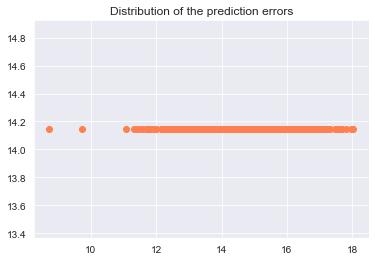

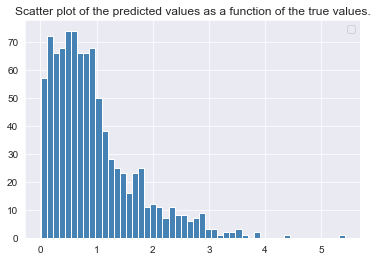

In [43]:
from sklearn import dummy

# 0) We create a dummy regressor model that always predicts the mean value of the feature to predict
dum = dummy.DummyRegressor(strategy='mean')

# 1) Training Dummy Regression
dum.fit(X_train, y_train)

# 2) Prediction on the testing set
y_pred_dum = dum.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Dummy Regressor", results, y_test, y_pred_dum)

R2 : -0.033648522972320905
Baseline error = MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365


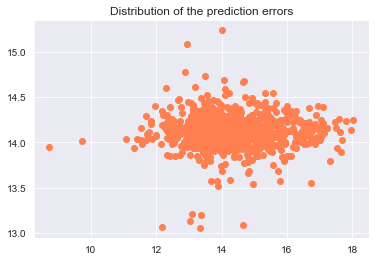

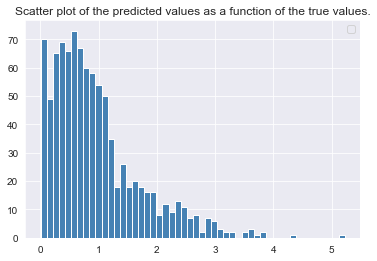

In [67]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

prediction_score = lr.score(X_test, y_test)
print('R2 : {}'.format(prediction_score))

results = evaluate_regression("Linear Regression", results, y_test, y_pred_lr)

In [101]:
baseline_error = mean_squared_error(y_test, y_pred_dum)
print("Baseline error = MSE from Dummy Regressor :", baseline_error)

Baseline error = MSE from Dummy Regressor : 1.438972208813029


#### 2) Linear Model : Ridge

In [48]:
# Setting evaluation metric for regression
scoring = 'r2'

##### 2.1) Trying Ridge Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [135]:
n_alphas = 1000 # hyperparametre alpha
alphas = np.logspace(2, 5, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((y_pred_ridge - y_test) ** 2))
    #print("HERE :", np.mean(( - y_test) ** 2), "MSE :", mean_squared_error(y_test, ridge.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for Ridge Regression : 1.4386000231205016
Best alpha for that minimal MSE :  4184.288507901585


(70.79457843841381, 141253.75446227554, 1.4383115329100682, 1.4446583175396044)

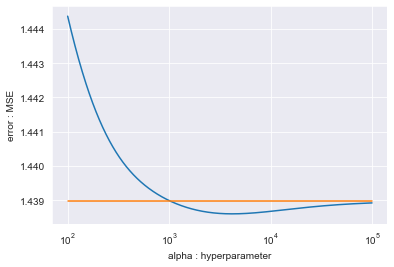

In [156]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [10**2, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(70.79457843841381,
 141253.75446227554,
 -0.09176544913924178,
 0.12341886397620741)

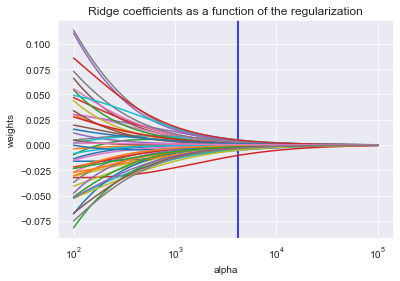

In [98]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

In [140]:
print("Getting y_pred for the best alpha : ", min_alpha)
ridge.set_params(alpha=min_alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Ridge manually", results, y_test, y_pred_ridge)

Getting y_pred for the best alpha :  4184.288507901585


##### 2.2) Optimization of hyperparameters

In [144]:
# define the model/ estimator
model = linear_model.Ridge()
params = {"alpha": np.logspace(-2, -1, n_alphas)} # alpha > 0
scoring = "neg_mean_squared_error"

# define the grid search
Ridge_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Ridge_reg.fit(X_train.values, y_train)

In [146]:
# best estimator
print("Best estimator :", Ridge_reg.best_estimator_)

# best model
best_model = Ridge_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_ridge = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Ridge GridSearchCV", results, y_test, y_pred_ridge)

Best estimator : Ridge(alpha=0.1)


Ridge(alpha=0.1)

In [150]:
print("QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? ")

QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? 


#### 3) Linear Model : LASSO

##### 3.1) Trying LASSO Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [173]:
n_alphas = 1000  # hyperparametre alpha
alphas = np.logspace(-2, -1, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred_lasso - y_test) ** 2))
    #print("HERE :", np.mean((lasso.predict(X_test) - y_test) ** 2), "MSE :", mean_squared_error(y_test, lasso.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for LASSO Regression : 1.4385616272233415
Best alpha for that minimal MSE :  0.01291549665014884


(0.008912509381337459,
 0.11220184543019636,
 1.438521561138697,
 1.439403015000875)

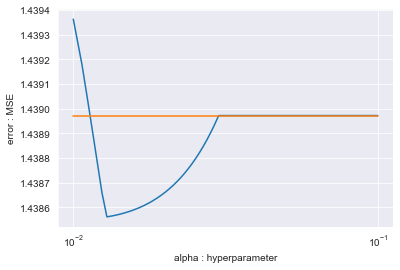

In [174]:
# recupere l'erreur min
print("Minimum Mean Squared Error for LASSO Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [10**-2, 10**-1], [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(0.008912509381337459,
 0.11220184543019636,
 -0.02377317768492499,
 0.007488522133236726)

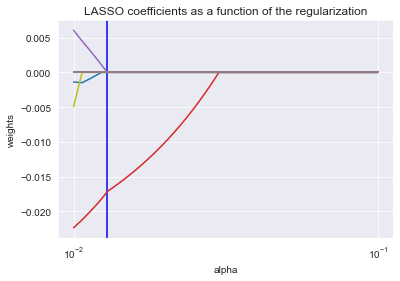

In [175]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  0.01291549665014884
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


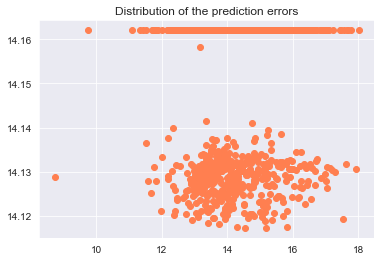

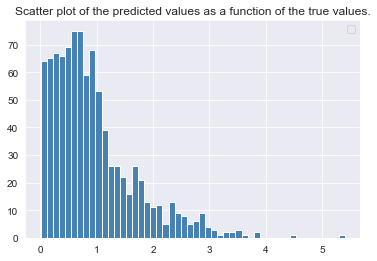

In [181]:
print("Getting y_pred for the best alpha : ", min_alpha)
lasso.set_params(alpha=min_alpha)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# 3) Evaluate
results = evaluate_regression("LASSO manually", results, y_test, y_pred_lasso)

In [182]:
y_pred_lasso

array([14.16203817, 14.13244654, 14.12782776, 14.16203817, 14.13061889,
       14.12555981, 14.16203817, 14.16203817, 14.16203817, 14.16203817,
       14.12785033, 14.16203817, 14.13024766, 14.16203817, 14.13245923,
       14.11727166, 14.1288276 , 14.16203817, 14.16203817, 14.12312929,
       14.16203817, 14.13080578, 14.12689467, 14.16203817, 14.12792623,
       14.12787677, 14.16203817, 14.12994317, 14.12896949, 14.16203817,
       14.16203817, 14.16203817, 14.12697589, 14.12952861, 14.16203817,
       14.13084373, 14.13388425, 14.16203817, 14.16203817, 14.16203817,
       14.16203817, 14.16203817, 14.16203817, 14.16203817, 14.16203817,
       14.12614704, 14.16203817, 14.16203817, 14.13715133, 14.13435623,
       14.13174417, 14.13197303, 14.16203817, 14.16203817, 14.16203817,
       14.16203817, 14.16203817, 14.16203817, 14.13507715, 14.13349261,
       14.13141627, 14.16203817, 14.16203817, 14.16203817, 14.16203817,
       14.16203817, 14.13116992, 14.13079835, 14.12639247, 14.13

##### 3.2) Optimization of hyperparameters

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best estimator : Lasso(alpha=0.052344600213237495)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


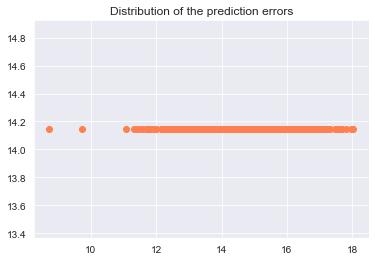

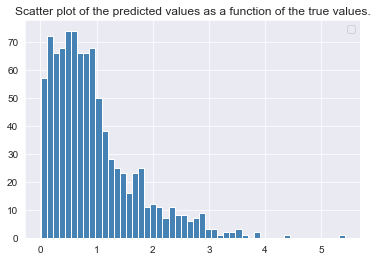

In [179]:
n_alphas = 10000
params = {"alpha": np.logspace(-2, 2, n_alphas)}

# define the model/ estimator
model = linear_model.Lasso()

# define the grid search
Lasso_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Lasso_reg.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", Lasso_reg.best_estimator_)

# best model
best_model = Lasso_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_lasso = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Lasso Regressor", results, y_test, y_pred_lasso)

In [183]:
y_pred_lasso
print("ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????")

ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????


#### 4) Linear Model : Elastic Net

##### 4.1) Trying Elastic Net Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameters alpha and l1_ratio

In [212]:
n = 100
l1_ratio = np.random.uniform(0, 1, size=(1, 100))
l1_ratio

l = [i / n for i in range(n)]
l = np.arange(0, 1, 10**-2)

l1_ratio = np.arange(start=0, stop=1, step= 1/n)
l1_ratio

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

alpha : 0.01 l1_ratio : 0.0 MSE : 1.4563364957943399
alpha : 0.01 l1_ratio : 0.1 MSE : 1.4520249556924008
alpha : 0.01 l1_ratio : 0.2 MSE : 1.4485548808954143
alpha : 0.01 l1_ratio : 0.3 MSE : 1.444770265042464
alpha : 0.01 l1_ratio : 0.4 MSE : 1.4416932800967053
alpha : 0.01 l1_ratio : 0.5 MSE : 1.44053487930508
alpha : 0.01 l1_ratio : 0.6 MSE : 1.4396361901071988
alpha : 0.01 l1_ratio : 0.7 MSE : 1.439101100919764
alpha : 0.01 l1_ratio : 0.8 MSE : 1.439115554445024
alpha : 0.01 l1_ratio : 0.9 MSE : 1.4392671854969228
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 0.027825594022071243 l1_ratio : 0.0 MSE : 1.4475038592958283
alpha : 0.027825594022071243 l1_ratio : 0.1 MSE : 1.442290243356249
alpha : 0.027825594022071243 l1_ratio : 0.2 MSE : 1.4396111895009855
alpha : 0.027825594022071243 l1_ratio : 0.3 MSE : 1.4391863038080333
alpha : 0.027825594022071243 l1_ratio : 0.4 MSE : 1.4390146542688607
alpha : 0.027825594022071243 l1_ratio : 0.5 MSE : 1.4385715115421367
alpha : 0.027825594022071243 l1_ratio : 0.6 MSE : 1.438604096162885
alpha : 0.027825594022071243 l1_ratio : 0.7 MSE : 1.4386516260517832
alpha : 0.027825594022071243 l1_ratio : 0.8 MSE : 1.4387143481907838
alpha : 0.027825594022071243 l1_ratio : 0.9 MSE : 1.4387925136712332
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 0.0774263682681127 l1_ratio : 0.0 MSE : 1.4419445364256387
alpha : 0.0774263682681127 l1_ratio : 0.1 MSE : 1.4391049916341392
alpha : 0.0774263682681127 l1_ratio : 0.2 MSE : 1.438596863680149
alpha : 0.0774263682681127 l1_ratio : 0.3 MSE : 1.4387486428904752
alpha : 0.0774263682681127 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 0.0774263682681127 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 0.0774263682681127 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 0.0774263682681127 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 0.0774263682681127 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 0.0774263682681127 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 0.21544346900318834 l1_ratio : 0.0 MSE : 1.4396538614183219
alpha : 0.21544346900318834 l1_ratio : 0.1 MSE : 1.4387306179912636
alpha : 0.21544346900318834 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 0.21544346900318834 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 0.5994842503189409 l1_ratio : 0.0 MSE : 1.4388379786363261
alpha : 0.5994842503189409 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 0.5994842503189409 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 1.6681005372000592 l1_ratio : 0.0 MSE : 1.4386023353509039
alpha : 1.6681005372000592 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 1.6681005372000592 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 4.6415888336127775 l1_ratio : 0.0 MSE : 1.438676587541931
alpha : 4.6415888336127775 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 4.6415888336127775 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 12.915496650148826 l1_ratio : 0.0 MSE : 1.4388168984159466
alpha : 12.915496650148826 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 12.915496650148826 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 35.93813663804626 l1_ratio : 0.0 MSE : 1.4389065833041987
alpha : 35.93813663804626 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 35.93813663804626 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


alpha : 100.0 l1_ratio : 0.0 MSE : 1.4389470933219608
alpha : 100.0 l1_ratio : 0.1 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.2 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.3 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.4 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.5 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.6 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.7 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.8 MSE : 1.438972208813029
alpha : 100.0 l1_ratio : 0.9 MSE : 1.438972208813029
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.19957,1.43897,0.93551,0.75529,-0.00482
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Linear Regression,1.21666,1.48025,0.94763,0.76414,-0.03365
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor Manually,1.19942,1.43860,0.93554,0.75111,-0.00456
0,Ridge Regressor,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.19945,1.43867,0.93550,0.75132,-0.00461
0,Ridge Regressor Manually,1.19955,1.43892,0.93550,0.75520,-0.00478
0,Ridge Regressor,1.21642,1.47968,0.94742,0.76423,-0.03325


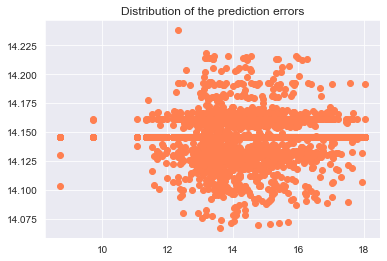

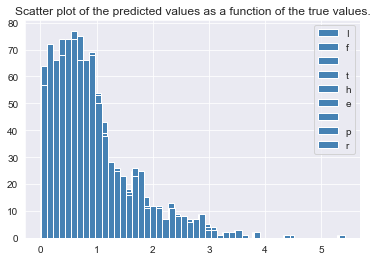

In [229]:
warnings.filterwarnings("ignore")

n_alphas = 10  # hyperparametre alpha
alphas = np.logspace(-2, 2, n_alphas)

n = 10
#l1_ratio = np.arange(start=0, stop=1, step= 1/n)
l1_ratio = [i / n for i in range(n)]

elastic = linear_model.ElasticNet()

coefs = []
errors = []
l1_all = []
all_mse = []

for a in alphas:
    for l1 in l1_ratio:
        elastic.set_params(alpha=a, l1_ratio=l1)
        elastic.fit(X_train, y_train)
        y_pred_elastic = elastic.predict(X_test)
        coefs.append(elastic.coef_)
        #print("HERE :", elastic.coef_)
        errors.append(np.mean((y_pred_elastic - y_test) ** 2))

        mse = mean_squared_error(y_test, elastic.predict(X_test))
        print("alpha :", a, "l1_ratio :", l1, "MSE :", mse)
        all_mse.append(mse)

        l1_all.append(l1)

    # find min mse
    mse_min_index = np.argmin(all_mse)
    # get l1 for the min mse
    l1_min = l1_all[mse_min_index]
    # train again with best l1
    elastic.set_params(alpha=a, l1_ratio=l1_min)
    elastic.fit(X_train, y_train)
    y_pred_elastic = elastic.predict(X_test)
    results = evaluate_regression("Elastic, alpha {}, l1_ratio : {}".format(a, l1_min), results, y_test, y_pred_elastic)

    errors.append(np.mean((y_pred_elastic - y_test) ** 2))

In [225]:
alphas

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [227]:
min_index = np.argmin(alphas)
min_alpha = alphas[min_index]
min_alpha

0.01

In [224]:
len(errors)

100

Minimum Mean Squared Error for Elastic Net Regression : 1.4385715115421367


ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

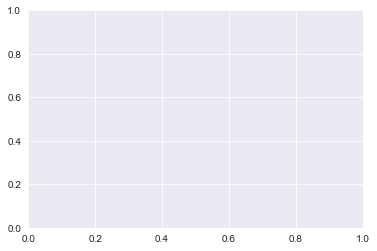

In [222]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Elastic Net Regression :", errors[np.argmin(errors)])
#print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [10**-2, 10**2], [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

array([[0.79703851, 0.41558502, 0.85391973, 0.92687361, 0.58690251,
        0.72048804, 0.13508727, 0.21535323, 0.42875395, 0.68092578,
        0.45317843, 0.49503401, 0.14048308, 0.79616509, 0.99268118,
        0.4709335 , 0.32350676, 0.38091807, 0.38198851, 0.3151652 ,
        0.25642182, 0.0689809 , 0.01291316, 0.50794757, 0.73596274,
        0.58982697, 0.57362398, 0.01882716, 0.69465133, 0.69821027,
        0.29547197, 0.94108849, 0.70374161, 0.28753001, 0.47662456,
        0.99307018, 0.99624419, 0.6868067 , 0.5819162 , 0.89163522,
        0.664661  , 0.74000845, 0.4204162 , 0.60781816, 0.86385601,
        0.75806668, 0.27405144, 0.78261031, 0.17174409, 0.94259814,
        0.21357715, 0.12294784, 0.97983523, 0.03394996, 0.19224807,
        0.5295786 , 0.19896702, 0.67813926, 0.97209565, 0.91835969,
        0.21212901, 0.31668356, 0.29234567, 0.18504428, 0.89197898,
        0.30027806, 0.76457686, 0.3700678 , 0.91631333, 0.44819235,
        0.35247132, 0.27082985, 0.9684548 , 0.04

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99]

##### 4.2) Optimization of hyperparameters

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [152]:
# 1) GridSearchCV or RandomizedSearchCV

In [151]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_forest = [{
    "regressor": [RandomForestRegressor(n_jobs=-1, random_state=seed, n_estimators=1000)], # random forest regressor
    "regressor__max_features": sp_randint(2, 5), # number of features to consider at each node
    "regressor__max_depth": sp_randint(2, 5), # maximum depth (to prune) a stump
    "regressor__min_samples_leaf": sp_randint(1, 100), # minimum number of samples required to be at a leaf node
}]


In [ ]:
# RFR
rfr = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest


#### 6) Adaboost

In [965]:
# Grid of research for AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_adaboost = [{
    "regressor": [AdaBoostRegressor(random_state=seed)], # AdaBoost regressor
    "regressor__base_estimator": [DecisionTreeRegressor()], # Required to tune the max_depth factor
    "regressor__base_estimator__max_depth": sp_randint(2, 5), #  [2,4]
    "regressor__n_estimators": sp_randint(50, 1000), # number of weak models to iteratively train
    "regressor__learning_rate": np.logspace(-2, 1, 4), # learning rate, from 10⁻² to 10¹
    "regressor__loss": ['linear', 'square', 'exponential'], # loss function for weights update
}]

#### 7) Gradient Boosting Regressor

#### SVR

In [966]:
# Grid of research for k-SVR
from sklearn.svm import SVR
from scipy.stats import expon
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_svr_poly = [{# hyper-parameters for polynomial kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['poly'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term
    "regressor__coef0" : [0, 1], # coef0 : independent term in kernel
    "regressor__degree" : sp_randint(1, 3), # degree of the polynomial kernel function
}]

param_grid_svr_linear = [{# hyper-parameters for linear kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['linear'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term. y = (x - loc) / scale
}]

param_grid_svr_gaussian = [{# hyper-parameters for gaussian kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['rbf'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term
    "regressor__gamma" : [0.0001, 0.001, 0.01, 0.1], # specific for gaussian kernel
}]


### III) Evaluation

### 1

In [1011]:

# Dictionnary of search spaces for each family of models
param_grids = {
    'Ridge': param_grid_ridge, # space of search for ElasticNet
    'LASSO': param_grid_lasso, # space of search for ElasticNet
    'ElasticNet': param_grid_elastic, # space of search for ElasticNet

    'RandomForest': param_grid_forest, # space of search for random forest
    'AdaBoost': param_grid_adaboost, # space of search for AdaBoost regressor

    'kSVR gaussian': param_grid_svr_gaussian, # space of search for k-SVR
    'kSVM poly': param_grid_svr_poly, # space of search for k-SVR with polynomial kernel
    'kSVM linear': param_grid_svr_linear # space of search for k-SVR
}
#'GradientBoosting': param_grid_gradientboost, # space of search for AdaBoost regressor


In [1012]:
for model, grid in param_grids.items():
    print(model)
    print(grid)

Ridge
[{'regressor': [Ridge(max_iter=1000)], 'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}]
LASSO
[{'regressor': [Lasso()], 'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}]
ElasticNet
[{'regressor': [ElasticNet()], 'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'regressor__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002BE25CD1730>}]
RandomForest
[{'regressor': [RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=350)], 'regressor__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002BE266D0850>, 'regressor__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002BE26B410A0>, 'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002BE25E3C0D0>}]
AdaBoost
[{'regressor': [AdaBoostRegressor(random_state=350)], 'regressor__base_estimator': [DecisionTreeRegressor()], 'regressor__base_estimator__max_depth': <

### 2

In [1013]:
param_grid_ridge[0]["regressor"][0]


Ridge(max_iter=1000)

In [1014]:
def all_gridSearchCV(features, target):

    # Load libraries
    from sklearn.model_selection import RandomizedSearchCV

    # Initialising the dict of results of RandomizedSearchCV
    CVsearch_dict = {}

    # Iterating over models and related parameters grids
    for model, param_grid in param_grids.items():
        print("\nProceeding RandomizedSearchCV for {}…".format(model))
        # Handle case where there are different dicts in param_grid (k-SVR…)
        for param_grid_dict in param_grid:

            # Intenciation of RandomizedSearchCV object
            grid = GridSearchCV(
                estimator=param_grid_dict["regressor"][0],
                param_grid=param_grid_dict, # choice of hyper-parameters to test
                scoring=scoring, # scoring method for regression
                cv=10, # cross-validation generator
                n_jobs=-1, # use all available cores (parallelization)
                return_train_score=True, # to avoid a DeprecationWarning
                verbose=1
            )

            # Searching for best hyper-parameters, and saving in dict
            CVsearch_dict[model] = grid.fit(features, target)

            # Getting standard deviation for best_model scores
            best_index = grid.best_index_
            std_score = grid.cv_results_['std_test_score'][best_index]

            # Displays the parameters of the best model
            print("Best parameters found for {}:".format(model))

            # Getting parameters from param_grid
            for parameter, _ in param_grid_dict.items():
                if parameter != 'regressor':
                    best_parameter = grid.best_estimator_.get_params()[parameter]
                    parameter = parameter.split("regressor__")[1]
                    # Display best parameter
                    print("  - " + parameter + ":", best_parameter)

            # Getting the best score
            print("\nMean cross-validated score of the best estimator for {}: R² = {:.3f} ± {:.3f}".format(model, grid.best_score_, std_score))

    # Returns dictionnary with results
    return CVsearch_dict

In [1015]:
CVsearch_dict = all_gridSearchCV(X_train, y_train)


Proceeding RandomizedSearchCV for Ridge…
Fitting 10 folds for each of 5 candidates, totalling 50 fits


ValueError: Invalid parameter 'regressor' for estimator Ridge(max_iter=1000). Valid parameters are: ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'].

In [1003]:
def get_best_model(CVsearch_dict):
    """Return the best_model from CVsearch_dict."""

    # Initializing best score
    best_score = 0

    # Iterating over models
    for model, model_CVsearch in CVsearch_dict.items():

        # Selecting model with best score
        if model_CVsearch.best_score_ > best_score:
            # Updating best_score and best_model
            best_model_name = model
            best_score = model_CVsearch.best_score_
            best_model = model_CVsearch.best_estimator_

    # Display results
    print("\nThe overall best cross-validated score is : R² = {:.3f}".format(best_score))
    print("The best model is {} with parameters: ".format(best_model_name))

    # Getting parameters from param_grid
    for parameter, _ in param_grids[best_model_name][0].items():
        if parameter != 'regressor':
            best_parameter = best_model.get_params()[parameter]

            # Display best parameter
            parameter = parameter.split("regressor__")[1]
            print("  - " + parameter + ":", best_parameter)

    return best_model

model_GHG = get_best_model(CVsearch_dict)

NameError: name 'CVsearch_dict' is not defined

#### Vérification des prédictions


#### Intérêt du Energy Star Score
